# Federated Learning In ResNet - Eye Disease Classifications

### Installing dependencies


In [1]:
!pip install flwr["simulation"]==0.18.0 torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 7.2 MB/s eta 0:00:00
  Obtaining dependency information for platformdirs<4,>=2.4 from https://files.pythonhosted.org/packages/56/29/3ec311dc18804409ecf0d2b09caa976f3ae6215559306b5b530004e11156/platformdirs-3.11.0-py3-none-any.whl.metadata
  Attempting uninstall: prometheus-client
    Found existing installation: prometheus-client 0.17.1
    Uninstalling prometheus-client-0.17.1:
      Successfully uninstalled prometheus-client-0.17.1
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.1.0
    Uninstal

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, utils
torch.manual_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cuda


### Data loading

In [3]:
class EyeImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root=root_dir, transform=transform)
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [4]:
root_directory = '/kaggle/input/dataset/'

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomRotation(degrees=5),
    transforms.RandomHorizontalFlip(p=0.5),
])

dataset = EyeImageDataset(root_dir=root_directory, transform=data_transform)

In [5]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.9), len(dataset)-int(len(dataset)*0.9)])

## Setting number of clients to simulate Federated Learning

In [6]:
NUM_CLIENTS = 3

In [7]:
num_clients = NUM_CLIENTS

# Split training set into `num_clients` partitions to simulate different local datasets
partition_size = len(train_dataset) // num_clients
lengths = [partition_size] * num_clients
datasets = random_split(train_dataset, lengths, torch.Generator().manual_seed(42))

# Split each partition into train/val and create DataLoader
train_loaders = []
val_loaders = []
for ds in datasets:
    len_val = len(ds) // 10  # 10 % validation set
    len_train = len(ds) - len_val
    lengths = [len_train, len_val]
    ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
    train_loaders.append(DataLoader(ds_train, batch_size=8, shuffle=True))
    val_loaders.append(DataLoader(ds_val, batch_size=8,shuffle=True))
test_loader = DataLoader(test_dataset, batch_size=8)

### Model training/evaluation


In [8]:
import torch
import torchvision.models as models
from torchvision.models import vgg19, VGG19_Weights
import torch.nn as nn
import tqdm

In [9]:
model = vgg19(weights = VGG19_Weights.IMAGENET1K_V1)

# freeze all the layers of VGG
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 223MB/s]


In [10]:
# modify the classifier layer
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1], nn.Linear(4096, 1024), nn.ReLU(), nn.Linear(1024,4))

In [11]:
ct = 0
for child in model.features:
    ct += 1
    if ct > 27:
        for param in child.parameters():
            param.requires_grad = True

In [12]:
# allow learning only for the linear layer
for param in model.classifier.parameters():
    param.requires_grad = True 

In [13]:
model = model.to(DEVICE)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
def evaluate(model, data_loader, criterion):
    """Evaluate the model on the given dataset."""
    # Set the model to evaluation mode.
    model.eval()
    correct = 0
    val_loss = 0
    count = 0
    # The `torch.no_grad()` context will turn off gradients for efficiency.
    with torch.no_grad():
        for images, labels in (data_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            output = model(images)
            pred = output.argmax(dim=1)
            loss = criterion(output, labels)
            correct += (pred == labels).sum().item()
            val_loss += loss.item() 
            count += 1
    return correct / len(data_loader.dataset), val_loss/count


def train(model, n_epoch, optimizer, scheduler, criterion, train_loader, valid_loader):
    """Train the model on the given dataset."""
    loss_ref = float('inf')
    for epoch in range(n_epoch):
        # Set the model to training mode.
        model.train()
        for step, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # 1. Clear previous gradients.
            optimizer.zero_grad()
            # 2. Forward pass. Calculate the output of the model.
            output = model(images)
            # 3. Calculate the loss.
            loss = criterion(output, labels)
            # 4. Calculate the gradients. PyTorch does this for us!
            loss.backward()
            # 5. Update the model parameters.
            optimizer.step()
            if step % 10 == 0:
                print(f"Epoch {epoch}, Step {step}, Loss {loss.item():.4f}")
        
        acc, val_loss = evaluate(model, valid_loader, criterion)
        scheduler.step(val_loss)
        print(f"Epoch {epoch}, Valid Accuracy {acc * 100:.2f}%") 
        
        if val_loss < loss_ref:
            patience = 5
            loss_ref = val_loss
        else:
            if patience == 0:
                print(f"[Early Stopping] Epoch {epoch}, Valid Accuracy {acc * 100:.2f}%, Valid Loss {val_loss:.4f}")
                return
            print(f"[INFO] Patience {patience} remaining")
            patience-=1

In [15]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
            {
                k: torch.Tensor(v) if v.shape != torch.Size([]) else torch.Tensor([0])
                for k, v in params_dict
            }
        )
    net.load_state_dict(state_dict, strict=True)

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### Flower client

Setting flower client. These flower clients represent a client on the federated learning model.

In [16]:
from logging import INFO, DEBUG
from flwr.common.logger import log

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.model = model.to(DEVICE)
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]
    
    def set_parameters(self, parameters: List[np.ndarray]) -> None:
        # Set model parameters from a list of NumPy ndarrays
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict(
                    {
                        k: torch.Tensor(v) if v.shape != torch.Size([]) else torch.Tensor([0])
                        for k, v in params_dict
                    }
                )
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        self.set_parameters(parameters)
        lr = 1e-3
        gamma = 0.9
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

        n_epoch = 20
        train(self.model, n_epoch, optimizer, scheduler,criterion,self.trainloader, self.valloader)
        return self.get_parameters(), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        self.set_parameters(parameters)
        criterion = nn.CrossEntropyLoss()
        accuracy, loss = evaluate(self.model, self.valloader, criterion)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    train_loader = train_loaders[int(cid)]
    val_loader = val_loaders[int(cid)]
    return FlowerClient(cid, model, train_loader, val_loader)

## Server Side Evaluation
We evalaute the accumulated model on the server after every federated round against the validation and test set

In [17]:
def get_evaluate_fn():

    def evaluate(
        parameters:  List[np.ndarray],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        val_loss, val_accuracy = test(model, val_loaders[0])
        test_loss, test_accuracy = test(model, test_loader)
        return val_loss, {"val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

    return evaluate

## Server Side Initialization and Simulation
We make use of FedAvg to accumulate the paramters from all the clients on the server. 

In [18]:
model_params = get_parameters(model.to(DEVICE))
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_eval=0.3,
    min_fit_clients=2,
    min_eval_clients=2,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.weights_to_parameters(get_parameters(model.to(DEVICE))),
    eval_fn=get_evaluate_fn(),  # Pass the evaluation function
    
)

#Start Simulation
res = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    num_rounds=7,
    strategy=strategy,
    client_resources = {'num_cpus': 4, 'num_gpus': 2}
)

INFO flower 2023-12-12 01:46:31,489 | app.py:144 | Ray initialized with resources: {'accelerator_type:T4': 1.0, 'memory': 18233032704.0, 'node:172.19.2.2': 1.0, 'object_store_memory': 9116516352.0, 'GPU': 2.0, 'CPU': 4.0}
INFO flower 2023-12-12 01:46:31,493 | app.py:153 | Starting Flower simulation running: {'num_rounds': 7}
INFO flower 2023-12-12 01:46:31,494 | server.py:128 | Initializing global parameters
INFO flower 2023-12-12 01:46:31,495 | server.py:323 | Using initial parameters provided by strategy
INFO flower 2023-12-12 01:46:31,496 | server.py:130 | Evaluating initial parameters
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antial

(launch_and_fit pid=305) [Client 1] fit, config: {}


(launch_and_fit pid=305) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=305)   warnings.warn(


(launch_and_fit pid=305) Epoch 0, Step 0, Loss 1.3318
(launch_and_fit pid=305) Epoch 0, Step 10, Loss 1.8281
(launch_and_fit pid=305) Epoch 0, Step 20, Loss 1.0988
(launch_and_fit pid=305) Epoch 0, Step 30, Loss 1.1148
(launch_and_fit pid=305) Epoch 0, Step 40, Loss 1.2578
(launch_and_fit pid=305) Epoch 0, Step 50, Loss 1.8998
(launch_and_fit pid=305) Epoch 0, Step 60, Loss 1.3898
(launch_and_fit pid=305) Epoch 0, Step 70, Loss 1.3892
(launch_and_fit pid=305) Epoch 0, Step 80, Loss 1.3596
(launch_and_fit pid=305) Epoch 0, Step 90, Loss 1.3920
(launch_and_fit pid=305) Epoch 0, Step 100, Loss 1.4071
(launch_and_fit pid=305) Epoch 0, Step 110, Loss 1.4048
(launch_and_fit pid=305) Epoch 0, Step 120, Loss 1.3850
(launch_and_fit pid=305) Epoch 0, Step 130, Loss 1.3847
(launch_and_fit pid=305) Epoch 0, Step 140, Loss 1.3783
(launch_and_fit pid=305) Epoch 0, Valid Accuracy 26.98%
(launch_and_fit pid=305) Epoch 1, Step 0, Loss 1.3855
(launch_and_fit pid=305) Epoch 1, Step 10, Loss 1.3824
(launc

(launch_and_fit pid=498) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=498)   warnings.warn(


(launch_and_fit pid=498) Epoch 0, Step 0, Loss 1.4370
(launch_and_fit pid=498) Epoch 0, Step 10, Loss 1.4464
(launch_and_fit pid=498) Epoch 0, Step 20, Loss 1.5677
(launch_and_fit pid=498) Epoch 0, Step 30, Loss 2.7974
(launch_and_fit pid=498) Epoch 0, Step 40, Loss 1.4046
(launch_and_fit pid=498) Epoch 0, Step 50, Loss 1.3869
(launch_and_fit pid=498) Epoch 0, Step 60, Loss 1.3810
(launch_and_fit pid=498) Epoch 0, Step 70, Loss 1.3655
(launch_and_fit pid=498) Epoch 0, Step 80, Loss 1.4307
(launch_and_fit pid=498) Epoch 0, Step 90, Loss 1.4184
(launch_and_fit pid=498) Epoch 0, Step 100, Loss 1.3917
(launch_and_fit pid=498) Epoch 0, Step 110, Loss 1.3883
(launch_and_fit pid=498) Epoch 0, Step 120, Loss 1.3764
(launch_and_fit pid=498) Epoch 0, Step 130, Loss 1.3882
(launch_and_fit pid=498) Epoch 0, Step 140, Loss 1.4031
(launch_and_fit pid=498) Epoch 0, Valid Accuracy 19.84%
(launch_and_fit pid=498) Epoch 1, Step 0, Loss 1.4121
(launch_and_fit pid=498) Epoch 1, Step 10, Loss 1.3792
(launc

DEBUG flower 2023-12-12 01:56:31,292 | server.py:277 | fit_round received 2 results and 0 failures
INFO flower 2023-12-12 01:56:46,322 | server.py:158 | fit progress: (1, 0.17626559355902294, {'val_accuracy': 0.25396825396825395, 'test_accuracy': 0.26540284360189575}, 590.005546631)
INFO flower 2023-12-12 01:56:46,323 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2023-12-12 01:56:46,325 | server.py:265 | fit_round: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=768) [Client 1] fit, config: {}


(launch_and_fit pid=768) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=768)   warnings.warn(


(launch_and_fit pid=768) Epoch 0, Step 0, Loss 1.3823
(launch_and_fit pid=768) Epoch 0, Step 10, Loss 1.2906
(launch_and_fit pid=768) Epoch 0, Step 20, Loss 1.4440
(launch_and_fit pid=768) Epoch 0, Step 30, Loss 1.3386
(launch_and_fit pid=768) Epoch 0, Step 40, Loss 1.3821
(launch_and_fit pid=768) Epoch 0, Step 50, Loss 1.3695
(launch_and_fit pid=768) Epoch 0, Step 60, Loss 1.3623
(launch_and_fit pid=768) Epoch 0, Step 70, Loss 1.3805
(launch_and_fit pid=768) Epoch 0, Step 80, Loss 1.3655
(launch_and_fit pid=768) Epoch 0, Step 90, Loss 1.3908
(launch_and_fit pid=768) Epoch 0, Step 100, Loss 1.3982
(launch_and_fit pid=768) Epoch 0, Step 110, Loss 1.4016
(launch_and_fit pid=768) Epoch 0, Step 120, Loss 1.3913
(launch_and_fit pid=768) Epoch 0, Step 130, Loss 1.3756
(launch_and_fit pid=768) Epoch 0, Step 140, Loss 1.3927
(launch_and_fit pid=768) Epoch 0, Valid Accuracy 17.46%
(launch_and_fit pid=768) Epoch 1, Step 0, Loss 1.3902
(launch_and_fit pid=768) Epoch 1, Step 10, Loss 1.4069
(launc

(launch_and_fit pid=960) 2023-12-12 02:00:48,588	ERROR serialization.py:342 -- CUDA error: out of memory
(launch_and_fit pid=960) CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
(launch_and_fit pid=960) For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
(launch_and_fit pid=960) Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
(launch_and_fit pid=960) Traceback (most recent call last):
(launch_and_fit pid=960)   File "/opt/conda/lib/python3.10/site-packages/ray/serialization.py", line 340, in deserialize_objects
(launch_and_fit pid=960)     obj = self._deserialize_object(data, metadata, object_ref)
(launch_and_fit pid=960)   File "/opt/conda/lib/python3.10/site-packages/ray/serialization.py", line 237, in _deserialize_object
(launch_and_fit pid=960)     return self._deserialize_msgpack_data(data, metadata_fields)
(launch_and_fit pid=960)   File "/opt/conda/lib/python3.10/site-packages/ray/seri

(launch_and_fit pid=998) [Client 0] fit, config: {}


(launch_and_fit pid=998) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=998)   warnings.warn(


(launch_and_fit pid=998) Epoch 0, Step 0, Loss 1.3856
(launch_and_fit pid=998) Epoch 0, Step 10, Loss 1.3805
(launch_and_fit pid=998) Epoch 0, Step 20, Loss 1.4148
(launch_and_fit pid=998) Epoch 0, Step 30, Loss 1.3645
(launch_and_fit pid=998) Epoch 0, Step 40, Loss 1.4000
(launch_and_fit pid=998) Epoch 0, Step 50, Loss 1.4740
(launch_and_fit pid=998) Epoch 0, Step 60, Loss 1.3834
(launch_and_fit pid=998) Epoch 0, Step 70, Loss 1.3721
(launch_and_fit pid=998) Epoch 0, Step 80, Loss 1.3756
(launch_and_fit pid=998) Epoch 0, Step 90, Loss 1.3848
(launch_and_fit pid=998) Epoch 0, Step 100, Loss 1.4128
(launch_and_fit pid=998) Epoch 0, Step 110, Loss 1.3688
(launch_and_fit pid=998) Epoch 0, Step 120, Loss 1.3840
(launch_and_fit pid=998) Epoch 0, Step 130, Loss 1.3967
(launch_and_fit pid=998) Epoch 0, Step 140, Loss 1.3568
(launch_and_fit pid=998) Epoch 0, Valid Accuracy 26.19%
(launch_and_fit pid=998) Epoch 1, Step 0, Loss 1.3785
(launch_and_fit pid=998) Epoch 1, Step 10, Loss 1.4091
(launc

(launch_and_fit pid=1263) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=1263)   warnings.warn(


(launch_and_fit pid=1263) Epoch 0, Step 0, Loss 1.4101
(launch_and_fit pid=1263) Epoch 0, Step 10, Loss 1.3862
(launch_and_fit pid=1263) Epoch 0, Step 20, Loss 1.4075
(launch_and_fit pid=1263) Epoch 0, Step 30, Loss 1.3651
(launch_and_fit pid=1263) Epoch 0, Step 40, Loss 1.3764
(launch_and_fit pid=1263) Epoch 0, Step 50, Loss 1.3841
(launch_and_fit pid=1263) Epoch 0, Step 60, Loss 1.4324
(launch_and_fit pid=1263) Epoch 0, Step 70, Loss 1.3815
(launch_and_fit pid=1263) Epoch 0, Step 80, Loss 1.4050
(launch_and_fit pid=1263) Epoch 0, Step 90, Loss 1.3795
(launch_and_fit pid=1263) Epoch 0, Step 100, Loss 1.3746
(launch_and_fit pid=1263) Epoch 0, Step 110, Loss 1.4132
(launch_and_fit pid=1263) Epoch 0, Step 120, Loss 1.3795
(launch_and_fit pid=1263) Epoch 0, Step 130, Loss 1.3835
(launch_and_fit pid=1263) Epoch 0, Step 140, Loss 1.3874
(launch_and_fit pid=1263) Epoch 0, Valid Accuracy 26.98%
(launch_and_fit pid=1263) Epoch 1, Step 0, Loss 1.4206
(launch_and_fit pid=1263) Epoch 1, Step 10, 

DEBUG flower 2023-12-12 02:11:08,112 | server.py:277 | fit_round received 2 results and 0 failures
INFO flower 2023-12-12 02:11:23,472 | server.py:158 | fit progress: (3, 0.17622614474523635, {'val_accuracy': 0.23015873015873015, 'test_accuracy': 0.26303317535545023}, 1467.155585556)
INFO flower 2023-12-12 02:11:23,474 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2023-12-12 02:11:23,475 | server.py:265 | fit_round: strategy sampled 2 clients (out of 3)


(scheduler +25m21s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +25m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 4.0, 'GPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_fit pid=1486) [Client 2] fit, config: {}


(launch_and_fit pid=1486) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=1486)   warnings.warn(


(launch_and_fit pid=1486) Epoch 0, Step 0, Loss 1.3931
(launch_and_fit pid=1486) Epoch 0, Step 10, Loss 1.3886
(launch_and_fit pid=1486) Epoch 0, Step 20, Loss 1.4008
(launch_and_fit pid=1486) Epoch 0, Step 30, Loss 1.4007
(launch_and_fit pid=1486) Epoch 0, Step 40, Loss 1.3766
(launch_and_fit pid=1486) Epoch 0, Step 50, Loss 1.3815
(launch_and_fit pid=1486) Epoch 0, Step 60, Loss 1.3871
(launch_and_fit pid=1486) Epoch 0, Step 70, Loss 1.3686


(raylet) Spilled 7680 MiB, 14 objects, write throughput 230 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


(launch_and_fit pid=1486) Epoch 0, Step 80, Loss 1.3672
(launch_and_fit pid=1486) Epoch 0, Step 90, Loss 1.3664
(launch_and_fit pid=1486) Epoch 0, Step 100, Loss 1.4400
(launch_and_fit pid=1486) Epoch 0, Step 110, Loss 1.3587
(launch_and_fit pid=1486) Epoch 0, Step 120, Loss 1.4688
(launch_and_fit pid=1486) Epoch 0, Step 130, Loss 1.5106
(launch_and_fit pid=1486) Epoch 0, Step 140, Loss 1.4225
(launch_and_fit pid=1486) Epoch 0, Valid Accuracy 19.84%
(launch_and_fit pid=1486) Epoch 1, Step 0, Loss 1.4196
(launch_and_fit pid=1486) Epoch 1, Step 10, Loss 1.3738
(launch_and_fit pid=1486) Epoch 1, Step 20, Loss 1.3994
(launch_and_fit pid=1486) Epoch 1, Step 30, Loss 1.3867
(launch_and_fit pid=1486) Epoch 1, Step 40, Loss 1.3826
(launch_and_fit pid=1486) Epoch 1, Step 50, Loss 1.3790
(launch_and_fit pid=1486) Epoch 1, Step 60, Loss 1.3825
(launch_and_fit pid=1486) Epoch 1, Step 70, Loss 1.3892
(launch_and_fit pid=1486) Epoch 1, Step 80, Loss 1.3713
(launch_and_fit pid=1486) Epoch 1, Step 90,

(launch_and_fit pid=1780) 2023-12-12 02:15:38,496	ERROR serialization.py:342 -- CUDA error: out of memory
(launch_and_fit pid=1780) CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
(launch_and_fit pid=1780) For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
(launch_and_fit pid=1780) Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
(launch_and_fit pid=1780) Traceback (most recent call last):
(launch_and_fit pid=1780)   File "/opt/conda/lib/python3.10/site-packages/ray/serialization.py", line 340, in deserialize_objects
(launch_and_fit pid=1780)     obj = self._deserialize_object(data, metadata, object_ref)
(launch_and_fit pid=1780)   File "/opt/conda/lib/python3.10/site-packages/ray/serialization.py", line 237, in _deserialize_object
(launch_and_fit pid=1780)     return self._deserialize_msgpack_data(data, metadata_fields)
(launch_and_fit pid=1780)   File "/opt/conda/lib/python3.10/site-package

(launch_and_fit pid=1818) [Client 1] fit, config: {}


(launch_and_fit pid=1818) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=1818)   warnings.warn(


(launch_and_fit pid=1818) Epoch 0, Step 0, Loss 1.3614
(launch_and_fit pid=1818) Epoch 0, Step 10, Loss 1.3658
(launch_and_fit pid=1818) Epoch 0, Step 20, Loss 1.3797
(launch_and_fit pid=1818) Epoch 0, Step 30, Loss 1.3774
(launch_and_fit pid=1818) Epoch 0, Step 40, Loss 1.3839
(launch_and_fit pid=1818) Epoch 0, Step 50, Loss 1.3909
(launch_and_fit pid=1818) Epoch 0, Step 60, Loss 1.3763
(launch_and_fit pid=1818) Epoch 0, Step 70, Loss 1.3806
(launch_and_fit pid=1818) Epoch 0, Step 80, Loss 1.4234
(launch_and_fit pid=1818) Epoch 0, Step 90, Loss 1.4293
(launch_and_fit pid=1818) Epoch 0, Step 100, Loss 1.3812
(launch_and_fit pid=1818) Epoch 0, Step 110, Loss 1.3549
(launch_and_fit pid=1818) Epoch 0, Step 120, Loss 1.4191
(launch_and_fit pid=1818) Epoch 0, Step 130, Loss 1.3565
(launch_and_fit pid=1818) Epoch 0, Step 140, Loss 1.4233
(launch_and_fit pid=1818) Epoch 0, Valid Accuracy 17.46%
(launch_and_fit pid=1818) Epoch 1, Step 0, Loss 1.4135
(launch_and_fit pid=1818) Epoch 1, Step 10, 

(raylet) Spilled 9326 MiB, 17 objects, write throughput 252 MiB/s.


(launch_and_fit pid=2154) [Client 2] fit, config: {}


(launch_and_fit pid=2154) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=2154)   warnings.warn(


(launch_and_fit pid=2154) Epoch 0, Step 0, Loss 1.3456
(launch_and_fit pid=2154) Epoch 0, Step 10, Loss 1.3807
(launch_and_fit pid=2154) Epoch 0, Step 20, Loss 1.3604
(launch_and_fit pid=2154) Epoch 0, Step 30, Loss 1.3589
(launch_and_fit pid=2154) Epoch 0, Step 40, Loss 1.4035
(launch_and_fit pid=2154) Epoch 0, Step 50, Loss 1.4280
(launch_and_fit pid=2154) Epoch 0, Step 60, Loss 1.4511
(launch_and_fit pid=2154) Epoch 0, Step 70, Loss 1.3907
(launch_and_fit pid=2154) Epoch 0, Step 80, Loss 1.3875
(launch_and_fit pid=2154) Epoch 0, Step 90, Loss 1.4195
(launch_and_fit pid=2154) Epoch 0, Step 100, Loss 1.3858
(launch_and_fit pid=2154) Epoch 0, Step 110, Loss 1.4087
(launch_and_fit pid=2154) Epoch 0, Step 120, Loss 1.3604
(launch_and_fit pid=2154) Epoch 0, Step 130, Loss 1.3606
(launch_and_fit pid=2154) Epoch 0, Step 140, Loss 1.3663
(launch_and_fit pid=2154) Epoch 0, Valid Accuracy 19.84%
(launch_and_fit pid=2154) Epoch 1, Step 0, Loss 1.3661
(launch_and_fit pid=2154) Epoch 1, Step 10, 

DEBUG flower 2023-12-12 02:30:22,988 | server.py:277 | fit_round received 2 results and 0 failures
INFO flower 2023-12-12 02:30:42,912 | server.py:158 | fit progress: (5, 0.17634660005569458, {'val_accuracy': 0.25396825396825395, 'test_accuracy': 0.26540284360189575}, 2626.595578198)
INFO flower 2023-12-12 02:30:42,913 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2023-12-12 02:30:42,914 | server.py:265 | fit_round: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=2488) [Client 2] fit, config: {}


(launch_and_fit pid=2488) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=2488)   warnings.warn(


(launch_and_fit pid=2488) Epoch 0, Step 0, Loss 1.3601
(launch_and_fit pid=2488) Epoch 0, Step 10, Loss 1.4136
(launch_and_fit pid=2488) Epoch 0, Step 20, Loss 1.3868
(launch_and_fit pid=2488) Epoch 0, Step 30, Loss 1.3938
(launch_and_fit pid=2488) Epoch 0, Step 40, Loss 1.3499
(launch_and_fit pid=2488) Epoch 0, Step 50, Loss 1.3755
(launch_and_fit pid=2488) Epoch 0, Step 60, Loss 1.4092
(launch_and_fit pid=2488) Epoch 0, Step 70, Loss 1.3801
(launch_and_fit pid=2488) Epoch 0, Step 80, Loss 1.3773
(launch_and_fit pid=2488) Epoch 0, Step 90, Loss 1.3853
(launch_and_fit pid=2488) Epoch 0, Step 100, Loss 1.3696
(launch_and_fit pid=2488) Epoch 0, Step 110, Loss 1.3547
(launch_and_fit pid=2488) Epoch 0, Step 120, Loss 1.4208
(launch_and_fit pid=2488) Epoch 0, Step 130, Loss 1.3736
(launch_and_fit pid=2488) Epoch 0, Step 140, Loss 1.3748
(launch_and_fit pid=2488) Epoch 0, Valid Accuracy 19.84%
(launch_and_fit pid=2488) Epoch 1, Step 0, Loss 1.3790
(launch_and_fit pid=2488) Epoch 1, Step 10, 

(launch_and_fit pid=2775) 2023-12-12 02:36:50,706	ERROR serialization.py:342 -- CUDA error: out of memory
(launch_and_fit pid=2775) CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
(launch_and_fit pid=2775) For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
(launch_and_fit pid=2775) Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
(launch_and_fit pid=2775) Traceback (most recent call last):
(launch_and_fit pid=2775)   File "/opt/conda/lib/python3.10/site-packages/ray/serialization.py", line 340, in deserialize_objects
(launch_and_fit pid=2775)     obj = self._deserialize_object(data, metadata, object_ref)
(launch_and_fit pid=2775)   File "/opt/conda/lib/python3.10/site-packages/ray/serialization.py", line 237, in _deserialize_object
(launch_and_fit pid=2775)     return self._deserialize_msgpack_data(data, metadata_fields)
(launch_and_fit pid=2775)   File "/opt/conda/lib/python3.10/site-package

(launch_and_fit pid=2813) [Client 1] fit, config: {}


(launch_and_fit pid=2813) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=2813)   warnings.warn(


(launch_and_fit pid=2813) Epoch 0, Step 0, Loss 1.3877
(launch_and_fit pid=2813) Epoch 0, Step 10, Loss 1.3342
(launch_and_fit pid=2813) Epoch 0, Step 20, Loss 1.3617
(launch_and_fit pid=2813) Epoch 0, Step 30, Loss 1.4383
(launch_and_fit pid=2813) Epoch 0, Step 40, Loss 1.3543
(launch_and_fit pid=2813) Epoch 0, Step 50, Loss 1.3772
(launch_and_fit pid=2813) Epoch 0, Step 60, Loss 1.4358
(launch_and_fit pid=2813) Epoch 0, Step 70, Loss 1.4361
(launch_and_fit pid=2813) Epoch 0, Step 80, Loss 1.3964
(launch_and_fit pid=2813) Epoch 0, Step 90, Loss 1.3742
(launch_and_fit pid=2813) Epoch 0, Step 100, Loss 1.3456
(launch_and_fit pid=2813) Epoch 0, Step 110, Loss 1.3785
(launch_and_fit pid=2813) Epoch 0, Step 120, Loss 1.3934
(launch_and_fit pid=2813) Epoch 0, Step 130, Loss 1.3996
(launch_and_fit pid=2813) Epoch 0, Step 140, Loss 1.3414
(launch_and_fit pid=2813) Epoch 0, Valid Accuracy 17.46%
(launch_and_fit pid=2813) Epoch 1, Step 0, Loss 1.3582
(launch_and_fit pid=2813) Epoch 1, Step 10, 

(launch_and_fit pid=3144) /opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=3144)   warnings.warn(


(launch_and_fit pid=3144) Epoch 0, Step 0, Loss 1.3830
(launch_and_fit pid=3144) Epoch 0, Step 10, Loss 1.3410
(launch_and_fit pid=3144) Epoch 0, Step 20, Loss 1.3554
(launch_and_fit pid=3144) Epoch 0, Step 30, Loss 1.3717
(launch_and_fit pid=3144) Epoch 0, Step 40, Loss 1.3743
(launch_and_fit pid=3144) Epoch 0, Step 50, Loss 1.4052
(launch_and_fit pid=3144) Epoch 0, Step 60, Loss 1.3700
(launch_and_fit pid=3144) Epoch 0, Step 70, Loss 1.3694
(launch_and_fit pid=3144) Epoch 0, Step 80, Loss 1.3858
(launch_and_fit pid=3144) Epoch 0, Step 90, Loss 1.3917
(launch_and_fit pid=3144) Epoch 0, Step 100, Loss 1.3864
(launch_and_fit pid=3144) Epoch 0, Step 110, Loss 1.3356
(launch_and_fit pid=3144) Epoch 0, Step 120, Loss 1.4114
(launch_and_fit pid=3144) Epoch 0, Step 130, Loss 1.3884
(launch_and_fit pid=3144) Epoch 0, Step 140, Loss 1.4192
(launch_and_fit pid=3144) Epoch 0, Valid Accuracy 19.84%
(launch_and_fit pid=3144) Epoch 1, Step 0, Loss 1.3163
(launch_and_fit pid=3144) Epoch 1, Step 10, 

DEBUG flower 2023-12-12 02:55:10,547 | server.py:277 | fit_round received 2 results and 0 failures
INFO flower 2023-12-12 02:55:27,542 | server.py:158 | fit progress: (7, 0.1766035244578407, {'val_accuracy': 0.25396825396825395, 'test_accuracy': 0.26540284360189575}, 4111.225466399001)
INFO flower 2023-12-12 02:55:27,543 | server.py:209 | evaluate_round: no clients selected, cancel
INFO flower 2023-12-12 02:55:27,544 | server.py:182 | FL finished in 4111.227268839
INFO flower 2023-12-12 02:55:27,625 | app.py:149 | app_fit: losses_distributed []
INFO flower 2023-12-12 02:55:27,627 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2023-12-12 02:55:27,628 | app.py:151 | app_fit: losses_centralized [(0, 0.1779284534000215), (1, 0.17626559355902294), (2, 0.17638013192585536), (3, 0.17622614474523635), (4, 0.17649534486588977), (5, 0.17634660005569458), (6, 0.17673997841184103), (7, 0.1766035244578407)]
INFO flower 2023-12-12 02:55:27,628 | app.py:152 | app_fit: metrics_centralized 

## Plotting Grpahs

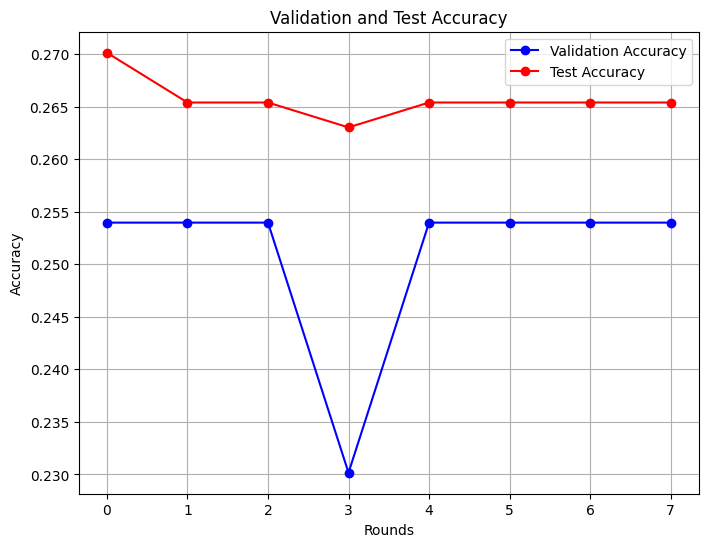

In [19]:
import matplotlib.pyplot as plt

rounds = [x for x in range(len(res.metrics_centralized['val_accuracy']))]
val_accuracies = [x[1] for x in res.metrics_centralized['val_accuracy']]
test_accuracies = [x[1] for x in res.metrics_centralized['test_accuracy']]

# Plotting
plt.figure(figsize=(8, 6))
# plt.ylim([-1,2])
plt.plot(rounds, val_accuracies, 'b',marker="o", label='Validation Accuracy')
plt.plot(rounds, test_accuracies, 'r',marker="o", label='Test Accuracy')
# plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Validation and Test Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

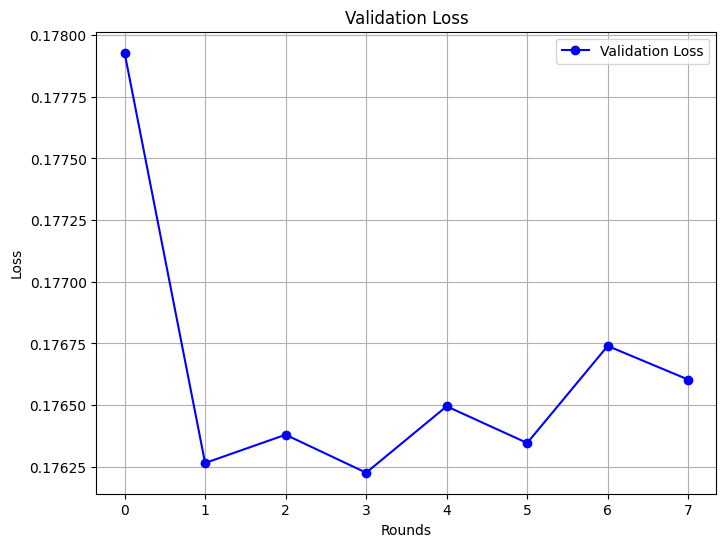

In [20]:
import matplotlib.pyplot as plt

rounds = range(0, len(res.losses_centralized))
val_losses = [x[1] for x in res.losses_centralized]

# Plotting
plt.figure(figsize=(8, 6))
# plt.ylim([-1,2])
plt.plot(rounds, val_losses, 'b', marker="o", label='Validation Loss')
# plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
res

History (loss, centralized):
	round 0: 0.1779284534000215
	round 1: 0.17626559355902294
	round 2: 0.17638013192585536
	round 3: 0.17622614474523635
	round 4: 0.17649534486588977
	round 5: 0.17634660005569458
	round 6: 0.17673997841184103
	round 7: 0.1766035244578407
History (metrics, centralized):
{'val_accuracy': [(0, 0.25396825396825395), (1, 0.25396825396825395), (2, 0.25396825396825395), (3, 0.23015873015873015), (4, 0.25396825396825395), (5, 0.25396825396825395), (6, 0.25396825396825395), (7, 0.25396825396825395)], 'test_accuracy': [(0, 0.27014218009478674), (1, 0.26540284360189575), (2, 0.26540284360189575), (3, 0.26303317535545023), (4, 0.26540284360189575), (5, 0.26540284360189575), (6, 0.26540284360189575), (7, 0.26540284360189575)]}